<a href="https://colab.research.google.com/github/micah-shull/pipelines/blob/main/pipelines_07_pytorch_pipeline_07_feature_engineering_threshold_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### What is a Threshold in Machine Learning?

In binary classification problems, the model outputs a probability score that represents the likelihood of a given instance belonging to the positive class (usually labeled as 1). A threshold is a decision point that determines how these probability scores are converted into class labels.

### How Threshold Works

- **Probability Scores**: The model outputs a probability score between 0 and 1 for each instance.
- **Threshold**: This is a value between 0 and 1 that you set. If the probability score is above the threshold, the instance is classified as the positive class (1). If the probability score is below the threshold, the instance is classified as the negative class (0).

### Default Threshold

- The default threshold is usually 0.5, meaning that instances with a probability score above 0.5 are classified as positive, and those below 0.5 are classified as negative.

### Adjusting the Threshold

Adjusting the threshold can help you balance different performance metrics, such as precision, recall, and F1-score. This is particularly important in imbalanced datasets where one class is more prevalent than the other.

- **Lower Threshold**: Increasing sensitivity (recall) for the positive class. More instances are classified as positive, potentially increasing false positives.
- **Higher Threshold**: Increasing specificity (precision) for the positive class. Fewer instances are classified as positive, potentially increasing false negatives.

### Impact on Metrics

- **Precision**: The ratio of true positives to the total predicted positives. It answers the question: "Of all instances predicted as positive, how many are actually positive?"
- **Recall**: The ratio of true positives to the total actual positives. It answers the question: "Of all actual positive instances, how many were predicted as positive?"
- **F1-Score**: The harmonic mean of precision and recall. It balances the two metrics, providing a single measure of performance.

### Example

- **Threshold 0.3**: More instances will be classified as positive, increasing recall but potentially lowering precision.
- **Threshold 0.7**: Fewer instances will be classified as positive, increasing precision but potentially lowering recall.

### Why Tune the Threshold?

- **Imbalanced Datasets**: In cases where one class is much more frequent than the other, adjusting the threshold can help achieve a better balance between precision and recall.
- **Specific Application Needs**: Depending on the problem, you might prioritize recall (e.g., detecting all fraud cases) or precision (e.g., ensuring that only actual fraud cases are flagged).

### Practical Steps

1. **Train the Model**: Train your binary classification model to output probability scores.
2. **Evaluate Performance**: Use different threshold values to see how precision, recall, and F1-score change.
3. **Select Optimal Threshold**: Choose the threshold that provides the best trade-off for your specific application needs.

### Conclusion

Threshold tuning is a crucial step in optimizing the performance of binary classification models, especially when dealing with imbalanced datasets. By carefully selecting the threshold, you can better balance precision and recall to meet the specific requirements of your application.

#### Should Your Data Determine Threshold?

Setting a threshold in a binary classification model involves careful consideration, and it's not always best to set the threshold to match the class distribution (e.g., 10% for a loan default ratio). Let's explore the implications of this approach:

### Setting the Threshold at 10%

If your loan default ratio is 10%, it means that 10% of your instances belong to the positive class (default), and 90% belong to the negative class (non-default). Setting the threshold at 10% means that any instance with a predicted probability of default greater than or equal to 0.1 will be classified as a default.

### Effects of Setting Threshold to Match Class Distribution

1. **High Sensitivity (Recall) for the Positive Class**:
   - **Pros**: More default instances will be correctly identified because the threshold is low.
   - **Cons**: This might lead to a higher number of false positives (non-defaults incorrectly classified as defaults).

2. **Low Precision for the Positive Class**:
   - **Pros**: Fewer defaults are missed.
   - **Cons**: Many non-defaults might be flagged as defaults, which can lead to unnecessary interventions or actions.

3. **Balanced Accuracy**:
   - Setting the threshold at 10% might not lead to balanced accuracy because the classifier might be biased towards predicting defaults more frequently.

### Implications on New, Unseen Data

1. **Model Robustness**:
   - If your model is well-calibrated and performs consistently on training and validation data, it might still perform reasonably well on new data.
   - However, unseen data can have different distributions, and a low threshold might not generalize well, leading to poor precision and potential overreaction to predicted defaults.

2. **Potential Overfitting**:
   - If the threshold is too low, the model might overfit to the positive class, causing it to predict defaults more often than necessary on new data.
   - This can be problematic in real-world scenarios where the cost of false positives is high.

3. **Business Implications**:
   - For loan default prediction, the cost of false positives (incorrectly predicting a default) might involve unnecessary interventions or denied loans to good customers.
   - Conversely, false negatives (failing to predict an actual default) could lead to financial losses.

### Finding the Optimal Threshold

To find the optimal threshold, consider the following approach:

1. **Evaluate Multiple Thresholds**:
   - Test various thresholds (e.g., 0.1, 0.2, ..., 0.9) and evaluate performance metrics such as precision, recall, F1-score, and accuracy.
   - Use a validation set to assess these metrics and find the threshold that provides the best balance for your specific needs.

2. **Cost-Benefit Analysis**:
   - Consider the business implications of false positives and false negatives. Determine the costs associated with each type of error and choose a threshold that minimizes the overall cost.

3. **ROC Curve and AUC**:
   - Use the ROC curve to visualize the trade-off between true positive rate (recall) and false positive rate. The Area Under the Curve (AUC) can provide an overall measure of model performance.

4. **Precision-Recall Curve**:
   - For imbalanced datasets, the precision-recall curve can be more informative than the ROC curve. It helps to understand the trade-off between precision and recall at different thresholds.

### Practical Steps

1. **Train the Model**: Train your binary classification model to output probability scores.
2. **Evaluate Performance**: Use different threshold values to see how precision, recall, and F1-score change.
3. **Select Optimal Threshold**: Choose the threshold that provides the best trade-off for your specific application needs.



### Initial Setup

In [1]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import logging
import matplotlib.pyplot as plt
import seaborn as sns
from model_pipeline import (
    load_data_from_url, clean_column_names, rename_columns, remove_id_column,
    convert_categorical, split_data, define_preprocessor, preprocess_data,
    calculate_class_weights, convert_to_tensors, SklearnSimpleNN, train_model, evaluate_model
)
from feature_engineering import (
    create_interaction_features, create_payment_to_bill_ratios,
    create_payment_to_limit_ratios, create_bill_to_limit_ratios,
    create_lagged_payment_differences, create_debt_ratio_features,
    create_average_payment_and_bill, create_payment_timeliness_features,
    create_total_payment_and_bill, create_bill_difference_features,
    bin_features, target_encode, rename_columns
)
from resampling_utils import (
    run_resampling_pipeline, reports_to_dataframe, apply_feature_set, plot_metric
)

### Load and Preprocess the Data

In [2]:
# # Load and Preprocess Data
# url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
# data = load_data_from_url(url)
# data = clean_column_names(data)
# data = rename_columns(data)
# data = remove_id_column(data)
# categorical_columns = ['sex', 'education', 'marriage']  # Specify your categorical columns
# data = convert_categorical(data, categorical_columns=categorical_columns)
# target = 'default_payment_next_month'  # Specify your target column

# # Apply feature engineering
# data = create_bill_to_limit_ratios(data)
# data = create_payment_to_limit_ratios(data)
# data = create_payment_timeliness_features(data)
# data = create_lagged_payment_differences(data)


def load_and_preprocess_data(url, categorical_columns, target):
    data = load_data_from_url(url)
    data = clean_column_names(data)
    data = rename_columns(data)
    data = remove_id_column(data)
    data = convert_categorical(data, categorical_columns=categorical_columns)
    return data, target

def apply_feature_engineering(data):
    data = create_bill_to_limit_ratios(data)
    data = create_payment_to_limit_ratios(data)
    data = create_payment_timeliness_features(data)
    data = create_lagged_payment_differences(data)
    return data



In [3]:
# Define Global Parameters
best_class_weight = 3.0
best_lower_threshold = 0.10

# Load and Preprocess Data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'education', 'marriage']  # Specify your categorical columns
target = 'default_payment_next_month'  # Specify your target column

data, target = load_and_preprocess_data(url, categorical_columns, target)

# Apply feature engineering
data = apply_feature_engineering(data)

### Define Threshold Tuning Function

In [4]:
def evaluate_thresholds(data, target, thresholds, pos_weight=1.0):
    X_train, X_test, y_train, y_test = split_data(data, target=target)
    preprocessor = define_preprocessor(X_train)

    X_train_processed, X_test_processed = preprocess_data(preprocessor, X_train, X_test)

    X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = convert_to_tensors(
        X_train_processed, y_train, X_test_processed, y_test)

    results = []
    for threshold in thresholds:
        nn_estimator = SklearnSimpleNN(input_dim=X_train_tensor.shape[1], pos_weight=pos_weight, threshold=threshold)
        nn_estimator = train_model(nn_estimator, X_train_tensor, y_train_tensor)
        report = evaluate_model(nn_estimator, X_test_tensor, y_test_tensor, label=f"Threshold {threshold}")
        results.append({'threshold': threshold, 'report': report})

    return results

def thresholds_to_dataframe(results):
    data = []
    for result in results:
        threshold = result['threshold']
        report = result['report']
        flattened_report = {'threshold': threshold}
        for key, subdict in report.items():
            if isinstance(subdict, dict):
                for subkey, value in subdict.items():
                    flattened_report[f"{key}_{subkey}"] = value
            else:
                flattened_report[key] = subdict
        data.append(flattened_report)
    return pd.DataFrame(data)


### Run and Evaluate

Classification Report (Threshold 0.1):
              precision    recall  f1-score   support

         0.0       0.97      0.10      0.18      4673
         1.0       0.24      0.99      0.38      1327

    accuracy                           0.30      6000
   macro avg       0.60      0.54      0.28      6000
weighted avg       0.81      0.30      0.23      6000

Classification Report (Threshold 0.2):
              precision    recall  f1-score   support

         0.0       0.94      0.25      0.39      4673
         1.0       0.26      0.95      0.41      1327

    accuracy                           0.40      6000
   macro avg       0.60      0.60      0.40      6000
weighted avg       0.79      0.40      0.40      6000

Classification Report (Threshold 0.30000000000000004):
              precision    recall  f1-score   support

         0.0       0.91      0.52      0.66      4673
         1.0       0.33      0.82      0.47      1327

    accuracy                           0.59      

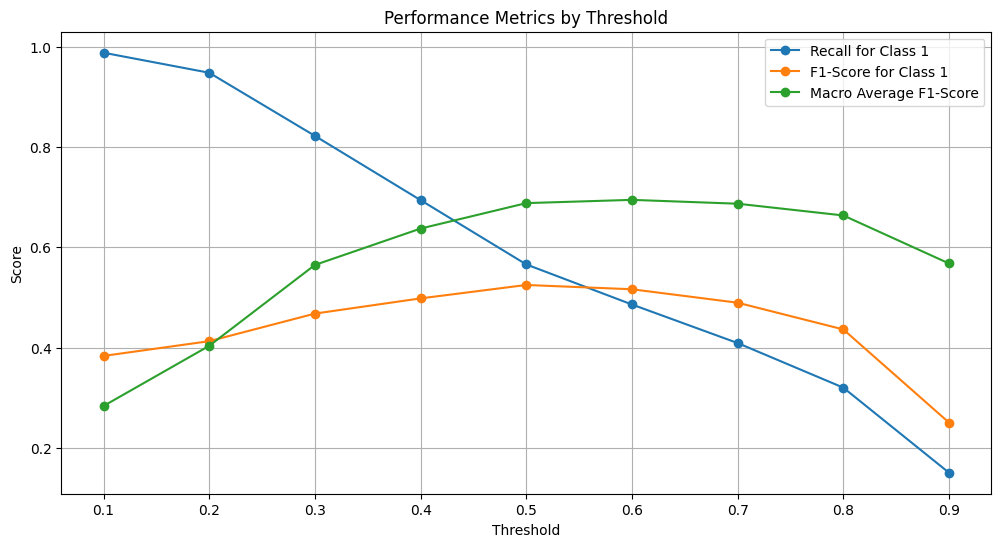

In [5]:
# Define the thresholds to evaluate
thresholds = np.linspace(0.1, 0.9, 9)

# Run the threshold evaluation without resampling
threshold_results = evaluate_thresholds(data, target, thresholds, best_class_weight)

# Convert the results to a DataFrame
threshold_results_df = thresholds_to_dataframe(threshold_results)

# Display the results
print(threshold_results_df[['threshold', '1.0_recall', '1.0_f1-score', 'macro avg_f1-score']])

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(threshold_results_df['threshold'], threshold_results_df['1.0_recall'], marker='o', label='Recall for Class 1')
plt.plot(threshold_results_df['threshold'], threshold_results_df['1.0_f1-score'], marker='o', label='F1-Score for Class 1')
plt.plot(threshold_results_df['threshold'], threshold_results_df['macro avg_f1-score'], marker='o', label='Macro Average F1-Score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Performance Metrics by Threshold')
plt.legend()
plt.grid(True)
plt.show()


### Analyze Results

### Threshold 0.3
- **1.0 Recall**: 0.822155
  - This means that the model correctly identifies 82.22% of actual defaults. This is a relatively high recall, indicating that the model is good at catching most of the default cases.
- **1.0 F1-Score**: 0.467939
  - The F1-score for the default class is 0.467939. This score balances precision and recall for the default class. At this threshold, the precision is lower, but the recall is high.
- **Macro Avg F1-Score**: 0.564895
  - The macro average F1-score is 0.564895, indicating a moderate balance of performance across both classes. This score takes into account the F1-scores for both the default and non-default classes equally.

### Threshold 0.4
- **1.0 Recall**: 0.694047
  - The recall drops to 69.40%, meaning the model is identifying fewer defaults compared to threshold 0.3, but it is still catching a significant number of default cases.
- **1.0 F1-Score**: 0.498242
  - The F1-score improves to 0.498242, suggesting a better balance between precision and recall. The precision increases at this threshold, leading to a higher F1-score.
- **Macro Avg F1-Score**: 0.637414
  - The macro average F1-score is 0.637414, indicating a better overall balance of performance across both classes compared to threshold 0.3. This score suggests that the model is performing well for both default and non-default classes.

### Threshold 0.5
- **1.0 Recall**: 0.565938
  - The recall drops further to 56.59%, meaning the model is identifying fewer default cases, but it is still capturing more than half of them.
- **1.0 F1-Score**: 0.524991
  - The F1-score increases to 0.524991, which is the highest among the three thresholds. This indicates the best balance between precision and recall for the default class.
- **Macro Avg F1-Score**: 0.688144
  - The macro average F1-score is 0.688144, which is also the highest among the three thresholds. This score suggests that the model's overall performance across both classes is optimal at this threshold.

### Summary of Key Insights

#### Threshold 0.3
- **High Recall**: The model catches most defaults (82.22%).
- **Moderate F1-Score**: The F1-score is lower due to lower precision, but recall is high.
- **Moderate Macro Avg F1-Score**: The overall performance is moderate.

#### Threshold 0.4
- **Good Balance**: The recall decreases, but the F1-score increases, indicating a better balance.
- **Higher Macro Avg F1-Score**: Overall performance improves compared to threshold 0.3.

#### Threshold 0.5
- **Balanced Performance**: The recall is lower, but the F1-score is highest, indicating the best balance between precision and recall.
- **Optimal Macro Avg F1-Score**: The highest macro average F1-score suggests the best overall performance across both classes.

### Recommendation

- **Threshold 0.5**: This threshold provides the best balance between recall and F1-score for the default class, along with the highest macro average F1-score. It is recommended to use this threshold for an optimal trade-off between identifying defaults and maintaining overall model performance.
- **Threshold 0.4**: If slightly higher recall is preferred at the expense of some precision, threshold 0.4 is also a good choice, providing a good balance and overall performance.
- **Threshold 0.3**: If the primary goal is to maximize recall and catch as many defaults as possible, threshold 0.3 can be considered, but be prepared for a trade-off in precision and overall balance.

Choosing the right threshold depends on the specific business requirements and the acceptable trade-offs between recall, precision, and overall model performance.

#### Write Resampling Script

In [1]:
# Function to write script
script_content = """

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report
from model_pipeline import (
    split_data, define_preprocessor, preprocess_data,
    convert_to_tensors, SklearnSimpleNN, train_model, evaluate_model
)
from feature_engineering import (
    create_interaction_features, create_payment_to_bill_ratios,
    create_payment_to_limit_ratios, create_bill_to_limit_ratios,
    create_lagged_payment_differences, create_debt_ratio_features,
    create_average_payment_and_bill, create_payment_timeliness_features,
    create_total_payment_and_bill, create_bill_difference_features,
    bin_features, target_encode, rename_columns
)

def run_resampling_pipeline(data, target, resampling_method=None, pos_weight=1.0, threshold=0.5):
    X_train, X_test, y_train, y_test = split_data(data, target=target)
    preprocessor = define_preprocessor(X_train)

    if resampling_method:
        resampling_pipeline = ImbPipeline(steps=[
            ('preprocessor', preprocessor),
            ('resampler', resampling_method)
        ])
        X_train_processed, y_train = resampling_pipeline.fit_resample(X_train, y_train)
        X_test_processed = preprocessor.transform(X_test)
    else:
        X_train_processed, X_test_processed = preprocess_data(preprocessor, X_train, X_test)

    X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = convert_to_tensors(
        X_train_processed, y_train, X_test_processed, y_test)

    nn_estimator = SklearnSimpleNN(input_dim=X_train_tensor.shape[1], pos_weight=pos_weight, threshold=threshold)
    nn_estimator = train_model(nn_estimator, X_train_tensor, y_train_tensor)
    report = evaluate_model(nn_estimator, X_test_tensor, y_test_tensor, label=str(resampling_method))
    return report

# Convert reports to DataFrame for analysis
def reports_to_dataframe(reports):
    data = []
    for method, report in reports.items():
        flattened_report = {'method': method}
        for key, subdict in report.items():
            if isinstance(subdict, dict):
                for subkey, value in subdict.items():
                    flattened_report[f"{key}_{subkey}"] = value
            else:
                flattened_report[key] = subdict
        data.append(flattened_report)
    return pd.DataFrame(data)

def apply_feature_set(data, feature_set):
    if 'bill_to_limit_ratios' in feature_set:
        data = create_bill_to_limit_ratios(data)
    if 'pay_to_limit_ratios' in feature_set:
        data = create_payment_to_limit_ratios(data)
    if 'payment_timeliness_features' in feature_set:
        data = create_payment_timeliness_features(data)
    if 'lagged_payment_differences' in feature_set:
        data = create_lagged_payment_differences(data)
    return data

def plot_metric(df, metric, title, ylabel):
    plt.figure(figsize=(14, 8))
    sns.barplot(x='method', y=metric, hue='feature_set', data=df, palette='viridis')
    plt.title(title)
    plt.xlabel('Resampling Method')
    plt.ylabel(ylabel)
    plt.legend(title='Feature Set')
    plt.xticks(rotation=45)
    plt.show()

"""

# Write the functions to feature_engineering.py script
with open("resampling_utils.py", "w") as file:
    file.write(script_content)

print("Functions successfully written to resampling_utils.py")

# reload script to make function available for use
import importlib
import resampling_utils
importlib.reload(resampling_utils)

from resampling_utils import (
    run_resampling_pipeline, reports_to_dataframe, apply_feature_set, plot_metric
)

Functions successfully written to resampling_utils.py


#### Write Pipeline Script

In [ ]:
script_content = """

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load the dataset from a URL
def load_data_from_url(url):
    df = pd.read_excel(url, header=1)
    return df

# Clean column names
def clean_column_names(df):
    df.columns = [col.lower().replace(' ', '_') for col in df.columns]
    return df

# Remove the 'id' column
def remove_id_column(df):
    if 'id' in df.columns:
        df = df.drop(columns=['id'])
    return df

# Rename columns (pay_0 not in dataset)
def rename_columns(df):
    rename_dict = {
        'pay_0': 'pay_1'
    }
    df = df.rename(columns=rename_dict)
    return df

# Convert specified columns to categorical type
def convert_categorical(df, categorical_columns):
    df[categorical_columns] = df[categorical_columns].astype('category')
    return df

# Split the data into training and testing sets
def split_data(df, target):
    X = df.drop(columns=[target])
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    return X_train, X_test, y_train, y_test

# Define the preprocessor
def define_preprocessor(X_train):
    numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])

    return preprocessor

# Preprocess the data
def preprocess_data(preprocessor, X_train, X_test):
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)
    return X_train_processed, X_test_processed

# Calculate class weights for imbalanced datasets
def calculate_class_weights(y_train):
    return len(y_train) / (2 * np.bincount(y_train))

# Convert data to PyTorch tensors
def convert_to_tensors(X_train_processed, y_train, X_test_processed, y_test):
    X_train_tensor = torch.tensor(X_train_processed, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
    X_test_tensor = torch.tensor(X_test_processed, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)
    return X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor

class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class SklearnSimpleNN(BaseEstimator, ClassifierMixin):
    def __init__(self, input_dim, learning_rate=0.001, epochs=50, batch_size=64,
                 pos_weight=1.0, threshold=0.5):
        self.input_dim = input_dim
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.pos_weight = pos_weight
        self.threshold = threshold
        self.model = SimpleNN(self.input_dim)

    def fit(self, X, y):
        criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(self.pos_weight, dtype=torch.float32))
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        train_dataset = torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32).unsqueeze(1))
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)

        for epoch in range(self.epochs):
            self.model.train()
            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs, targets.view(-1, 1))
                loss.backward()
                optimizer.step()
        return self

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            if isinstance(X, np.ndarray):
                X = torch.tensor(X, dtype=torch.float32)
            elif isinstance(X, pd.DataFrame):
                X = torch.tensor(X.values, dtype=torch.float32)
            outputs = self.model(X)
            probabilities = torch.sigmoid(outputs)
            predictions = (probabilities > self.threshold).float()
        return predictions.numpy().squeeze()

# Train the Model
def train_model(nn_estimator, X_train_tensor, y_train_tensor):
    nn_estimator.fit(X_train_tensor.numpy(), y_train_tensor.numpy())
    return nn_estimator

# Evaluate the Model
def evaluate_model(nn_estimator, X_test_tensor, y_test_tensor, label=""):
    y_pred = nn_estimator.predict(X_test_tensor.numpy())
    report = classification_report(y_test_tensor.numpy(), y_pred, output_dict=True)
    print(f"Classification Report ({label}):")
    print(classification_report(y_test_tensor.numpy(), y_pred))
    return report

# Function to run the full pipeline with resampling
def run_full_pipeline_with_resampling(url, categorical_columns, target, resampling_method=None):
    data = load_data_from_url(url)
    data = clean_column_names(data)
    data = rename_columns(data)
    data = remove_id_column(data)
    data = convert_categorical(data, categorical_columns=categorical_columns)
    X_train, X_test, y_train, y_test = split_data(data, target=target)
    preprocessor = define_preprocessor(X_train)

    if resampling_method:
        resampling_pipeline = ImbPipeline(steps=[
            ('preprocessor', preprocessor),
            ('resampler', resampling_method)
        ])
        X_train_processed, y_train = resampling_pipeline.fit_resample(X_train, y_train)
        X_test_processed = preprocessor.transform(X_test)
    else:
        X_train_processed, X_test_processed = preprocess_data(preprocessor, X_train, X_test)

    class_weights = calculate_class_weights(y_train)

    X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = convert_to_tensors(
        X_train_processed, y_train, X_test_processed, y_test)

    nn_estimator = SklearnSimpleNN(input_dim=X_train_tensor.shape[1], pos_weight=class_weights[1])
    nn_estimator = train_model(nn_estimator, X_train_tensor, y_train_tensor)
    evaluate_model(nn_estimator, X_test_tensor, y_test_tensor)

if __name__ == "__main__":
    import argparse

    parser = argparse.ArgumentParser(description="Run full pipeline with resampling")
    parser.add_argument("url", type=str, help="URL of the dataset")
    parser.add_argument("categorical_columns", type=str, nargs="+", help="List of categorical columns")
    parser.add_argument("target", type=str, help="Target column")
    parser.add_argument("--resampling", type=str, choices=['smote', 'oversample', 'undersample'], help="Resampling method")

    args = parser.parse_args()

    if args.resampling == 'smote':
        resampling_method = SMOTE(random_state=42)
    elif args.resampling == 'oversample':
        resampling_method = RandomOverSampler(random_state=42)
    elif args.resampling == 'undersample':
        resampling_method = RandomUnderSampler(random_state=42)
    else:
        resampling_method = None

    run_full_pipeline_with_resampling(args.url, args.categorical_columns, args.target, resampling_method)


"""

# Write the functions to model_pipeline.py script
with open("model_pipeline.py", "w") as file:
    file.write(script_content)

print("Functions successfully written to model_pipeline.py")

# reload script to make function available for use
import importlib
import model_pipeline
importlib.reload(model_pipeline)
